In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import utils
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 10, 9, 3, 42, 413234)

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-10 09:03:42,458 INFO: Initializing external client


2025-01-10 09:03:42,460 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-01-10 09:03:43,869 INFO: Python Engine initialized.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494


In [5]:
CITY = "dublin"
STATION = "HEUSTON BRIDGE (NORTH)"

STATION = STATION.replace(" ", "_")

In [6]:
feature_view = fs.get_feature_view(
    name='bike_weather_fw',
    version=1,
)

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="bike_availability_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [8]:
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

In [9]:
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)

batch_data = weather_fg.filter(weather_fg.datetime >= today).read()
batch_data["month"] = batch_data["datetime"].dt.month
batch_data["weekday"] = batch_data["datetime"].dt.weekday  # 0=Monday, 6=Sunday
batch_data["hour"] = batch_data["datetime"].dt.hour
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.97s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour
0,2025-01-16 22:00:00+00:00,7.45,4.772952,0.0,0.0,11.620809,29183.220703,0.0,dublin,1,3,22
1,2025-01-14 08:00:00+00:00,11.25,8.629154,0.0,0.0,18.079027,28859.789062,0.0,dublin,1,1,8
2,2025-01-15 15:00:00+00:00,10.55,7.494875,0.0,0.0,15.782622,29019.097656,0.0,dublin,1,2,15
3,2025-01-12 03:00:00+00:00,1.85,-0.727269,0.0,0.0,4.510787,28556.771484,0.0,dublin,1,6,3
4,2025-01-12 01:00:00+00:00,1.85,-0.729685,0.0,0.0,4.693825,28556.771484,0.0,dublin,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
224,2025-01-19 21:00:00+00:00,7.20,2.150184,0.0,0.0,24.122686,29701.466797,3.6,dublin,1,6,21
225,2025-01-19 02:00:00+00:00,11.95,8.386806,0.4,0.0,25.924999,29701.466797,3.6,dublin,1,6,2
226,2025-01-19 11:00:00+00:00,10.25,4.566900,0.1,0.0,29.758307,29701.466797,3.6,dublin,1,6,11
227,2025-01-19 23:00:00+00:00,7.15,2.518229,0.0,0.0,21.674870,29701.466797,3.6,dublin,1,6,23


## Creating predictions

In [10]:
batch_data['predicted_bikes_available'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['predicted_bikes_available'] = batch_data['predicted_bikes_available'].apply(lambda x: round(x))

batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available
0,2025-01-16 22:00:00+00:00,7.45,4.772952,0.0,0.0,11.620809,29183.220703,0.0,dublin,1,3,22,38
1,2025-01-14 08:00:00+00:00,11.25,8.629154,0.0,0.0,18.079027,28859.789062,0.0,dublin,1,1,8,24
2,2025-01-15 15:00:00+00:00,10.55,7.494875,0.0,0.0,15.782622,29019.097656,0.0,dublin,1,2,15,5
3,2025-01-12 03:00:00+00:00,1.85,-0.727269,0.0,0.0,4.510787,28556.771484,0.0,dublin,1,6,3,38
4,2025-01-12 01:00:00+00:00,1.85,-0.729685,0.0,0.0,4.693825,28556.771484,0.0,dublin,1,6,1,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,2025-01-19 21:00:00+00:00,7.20,2.150184,0.0,0.0,24.122686,29701.466797,3.6,dublin,1,6,21,31
225,2025-01-19 02:00:00+00:00,11.95,8.386806,0.4,0.0,25.924999,29701.466797,3.6,dublin,1,6,2,32
226,2025-01-19 11:00:00+00:00,10.25,4.566900,0.1,0.0,29.758307,29701.466797,3.6,dublin,1,6,11,33
227,2025-01-19 23:00:00+00:00,7.15,2.518229,0.0,0.0,21.674870,29701.466797,3.6,dublin,1,6,23,32


In [11]:
# Fill in the number of hours before the time on which you made the forecast (base_datetime)
batch_data = batch_data.sort_values(by=['datetime'])
batch_data['hours_before_forecast_time'] = range(1, len(batch_data) + 1)
batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
69,2025-01-10 11:00:00+00:00,4.20,0.015389,0.0,0.0,13.708390,28276.632812,0.0,dublin,1,4,11,36,1
165,2025-01-10 12:00:00+00:00,4.75,0.458129,0.0,0.0,14.386494,28276.632812,0.0,dublin,1,4,12,31,2
108,2025-01-10 13:00:00+00:00,4.85,0.452495,0.0,0.0,15.003839,28276.632812,0.0,dublin,1,4,13,33,3
175,2025-01-10 14:00:00+00:00,4.70,0.209122,0.0,0.0,15.294703,28276.632812,0.0,dublin,1,4,14,32,4
105,2025-01-10 15:00:00+00:00,4.60,-0.006577,0.0,0.0,15.790833,28276.632812,0.0,dublin,1,4,15,33,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,2025-01-19 19:00:00+00:00,7.50,2.203819,0.0,0.0,25.704100,29701.466797,3.6,dublin,1,6,19,28,225
215,2025-01-19 20:00:00+00:00,7.30,2.118057,0.0,0.0,24.912935,29701.466797,3.6,dublin,1,6,20,31,226
224,2025-01-19 21:00:00+00:00,7.20,2.150184,0.0,0.0,24.122686,29701.466797,3.6,dublin,1,6,21,31,227
216,2025-01-19 22:00:00+00:00,7.15,2.323161,0.0,0.0,22.771244,29701.466797,3.6,dublin,1,6,22,32,228


## Create forecast graph

2025-01-10 09:03:53,878 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



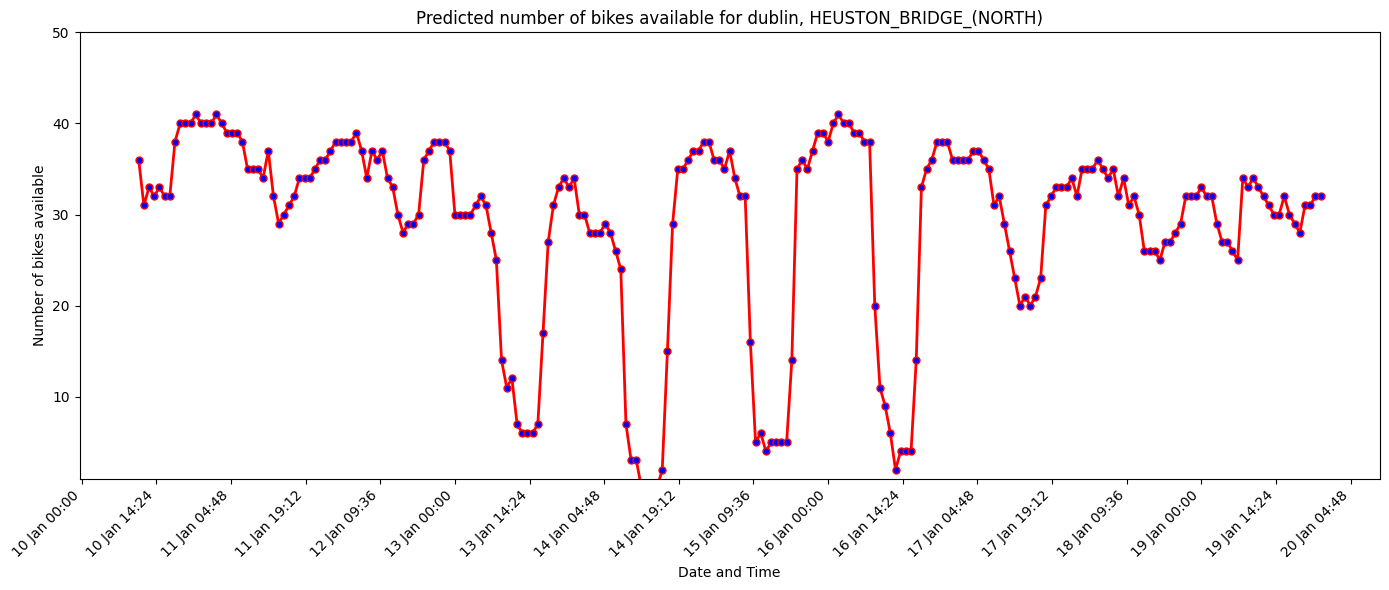

In [12]:
file_path = "docs/bike_availability_forecast.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='bike_availability_predictions',
    description='Bike availability prediction monitoring for ' + STATION.replace("_", " "),
    version=1,
    primary_key=["datetime", "city"],
    event_time="datetime"
)

In [14]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |                                     | Rows 0/229 | Elapsed Time: 00:00 | Remaining Time: ?

Uploading Dataframe: 89.08% |██████████████████████████▋   | Rows 204/229 | Elapsed Time: 00:01 | Remaining Time: 00:00

Uploading Dataframe: 100.00% |█████████████████████████████| Rows 229/229 | Elapsed Time: 00:01 | Remaining Time: 00:00

Launching job: bike_availability_predictions_1_offline_fg_materialization


Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions


2025-01-10 09:04:09,239 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED


2025-01-10 09:04:12,416 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


2025-01-10 09:05:57,290 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED


2025-01-10 09:05:57,443 INFO: Waiting for log aggregation to finish.


2025-01-10 09:06:09,346 INFO: Execution finished successfully.


(Job('bike_availability_predictions_1_offline_fg_materialization', 'SPARK'),
 None)

In [15]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.hours_before_forecast_time <= 24).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.09s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
0,2025-01-10 13:00:00+00:00,4.8500,0.452495,0.0,0.0,15.003839,28276.632812,0.0,dublin,1,4,13,33,3
1,2025-01-10 19:00:00+00:00,4.7000,-0.266024,0.0,0.0,16.923830,28276.632812,0.0,dublin,1,4,19,40,9
2,2025-01-11 09:00:00+00:00,4.7500,1.359584,0.3,0.0,12.904882,28413.685547,1.8,dublin,1,5,9,35,23
3,2025-01-08 20:00:00+00:00,-1.0000,-5.029679,0.0,0.0,10.948973,28021.865234,0.0,dublin,1,2,20,40,2
4,2025-01-11 04:00:00+00:00,4.8500,0.594526,0.1,0.0,16.087610,28413.685547,1.8,dublin,1,5,4,39,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2024-12-29 12:00:00+00:00,10.0895,6.403931,0.0,0.0,21.675617,27249.105469,0.0,dublin,12,6,12,30,21
84,2024-12-29 00:00:00+00:00,7.9395,5.065456,0.0,0.0,13.619471,27249.105469,0.0,dublin,12,6,0,35,9
85,2024-12-28 17:00:00+00:00,8.7895,5.991804,0.0,0.0,15.070633,27194.826172,0.0,dublin,12,5,17,31,2
86,2024-12-29 05:00:00+00:00,6.4395,2.621438,0.0,0.0,18.329973,27249.105469,0.0,dublin,12,6,5,35,14


In [16]:
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
bike_df = bike_fg.read()
bike_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.18s) 


,datetime,station,num_bikes_available
0,2024-09-23 10:00:00+00:00,HEUSTON_BRIDGE_(NORTH),2.0
1,2023-10-07 13:00:00+00:00,HEUSTON_BRIDGE_(NORTH),29.0
2,2023-11-27 07:00:00+00:00,HEUSTON_BRIDGE_(NORTH),34.0
3,2024-01-22 22:00:00+00:00,HEUSTON_BRIDGE_(NORTH),35.0
4,2023-10-16 02:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
...,...,...,...
9305,2025-01-09 06:39:54+00:00,HEUSTON_BRIDGE_(NORTH),39.0
9306,2025-01-09 08:49:51+00:00,HEUSTON_BRIDGE_(NORTH),38.0
9307,2025-01-09 14:49:45+00:00,HEUSTON_BRIDGE_(NORTH),20.0
9308,2025-01-09 18:50:05+00:00,HEUSTON_BRIDGE_(NORTH),40.0


In [17]:
weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.63s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,2024-11-17 07:00:00+00:00,6.6395,3.542508,0.0,0.0,13.091829,30647.093750,2.6,dublin
1,2024-07-26 02:00:00+00:00,12.0395,9.959105,0.0,0.0,15.349684,57427.019531,0.9,dublin
2,2024-08-02 09:00:00+00:00,18.9895,18.108223,0.0,0.0,19.469975,56053.718750,2.5,dublin
3,2024-03-28 18:00:00+00:00,8.1395,6.004910,0.1,0.0,4.334974,46005.636719,1.3,dublin
4,2024-01-09 08:00:00+00:00,3.7895,-1.855704,0.0,0.0,21.602999,28177.490234,0.0,dublin
...,...,...,...,...,...,...,...,...,...
12739,2025-01-19 21:00:00+00:00,7.2000,2.150184,0.0,0.0,24.122686,29701.466797,3.6,dublin
12740,2025-01-19 02:00:00+00:00,11.9500,8.386806,0.4,0.0,25.924999,29701.466797,3.6,dublin
12741,2025-01-19 11:00:00+00:00,10.2500,4.566900,0.1,0.0,29.758307,29701.466797,3.6,dublin
12742,2025-01-19 23:00:00+00:00,7.1500,2.518229,0.0,0.0,21.674870,29701.466797,3.6,dublin


In [18]:
def backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, model):
    features_df = weather_fg.read()

    features_df["month"] = features_df["datetime"].dt.month
    features_df["weekday"] = features_df["datetime"].dt.weekday  # 0=Monday, 6=Sunday
    features_df["hour"] = features_df["datetime"].dt.hour

    features_df = pd.merge(features_df, bike_df[['datetime','num_bikes_available']], on="datetime")
    features_df = features_df.sort_values(by=['datetime'], ascending=True)
    features_df = features_df.tail(10*24)
    
    features_df['predicted_bikes_available'] = model.predict(features_df[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']])
    features_df['predicted_bikes_available'] = features_df['predicted_bikes_available'].apply(lambda x: round(x))

    features_df['hours_before_forecast_time'] = range(1, len(features_df) + 1)
    hindcast_df = features_df
    features_df = features_df.drop('num_bikes_available', axis=1)
    monitor_fg.insert(features_df, write_options={"wait_for_job": True})
    return hindcast_df

In [19]:
outcome_df = bike_df[['datetime', 'num_bikes_available']]
preds_df =  monitoring_df[['datetime', 'predicted_bikes_available']]

hindcast_df = pd.merge(preds_df, outcome_df, on="datetime")
hindcast_df = hindcast_df.sort_values(by=['datetime'])
print(len(hindcast_df))
hindcast_df

24


,datetime,predicted_bikes_available,num_bikes_available
12,2024-12-28 16:00:00+00:00,32,34.0
21,2024-12-28 17:00:00+00:00,31,33.0
6,2024-12-28 18:00:00+00:00,32,34.0
17,2024-12-28 19:00:00+00:00,32,33.0
7,2024-12-28 20:00:00+00:00,32,34.0
10,2024-12-28 21:00:00+00:00,36,34.0
16,2024-12-28 22:00:00+00:00,34,34.0
4,2024-12-28 23:00:00+00:00,34,35.0
20,2024-12-29 00:00:00+00:00,35,35.0
2,2024-12-29 01:00:00+00:00,35,35.0


In [20]:

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
print("Hindcast length: ", len(hindcast_df))
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Hindcast length:  24


,datetime,predicted_bikes_available,num_bikes_available
12,2024-12-28 16:00:00+00:00,32,34.0
21,2024-12-28 17:00:00+00:00,31,33.0
6,2024-12-28 18:00:00+00:00,32,34.0
17,2024-12-28 19:00:00+00:00,32,33.0
7,2024-12-28 20:00:00+00:00,32,34.0
10,2024-12-28 21:00:00+00:00,36,34.0
16,2024-12-28 22:00:00+00:00,34,34.0
4,2024-12-28 23:00:00+00:00,34,35.0
20,2024-12-29 00:00:00+00:00,35,35.0
2,2024-12-29 01:00:00+00:00,35,35.0


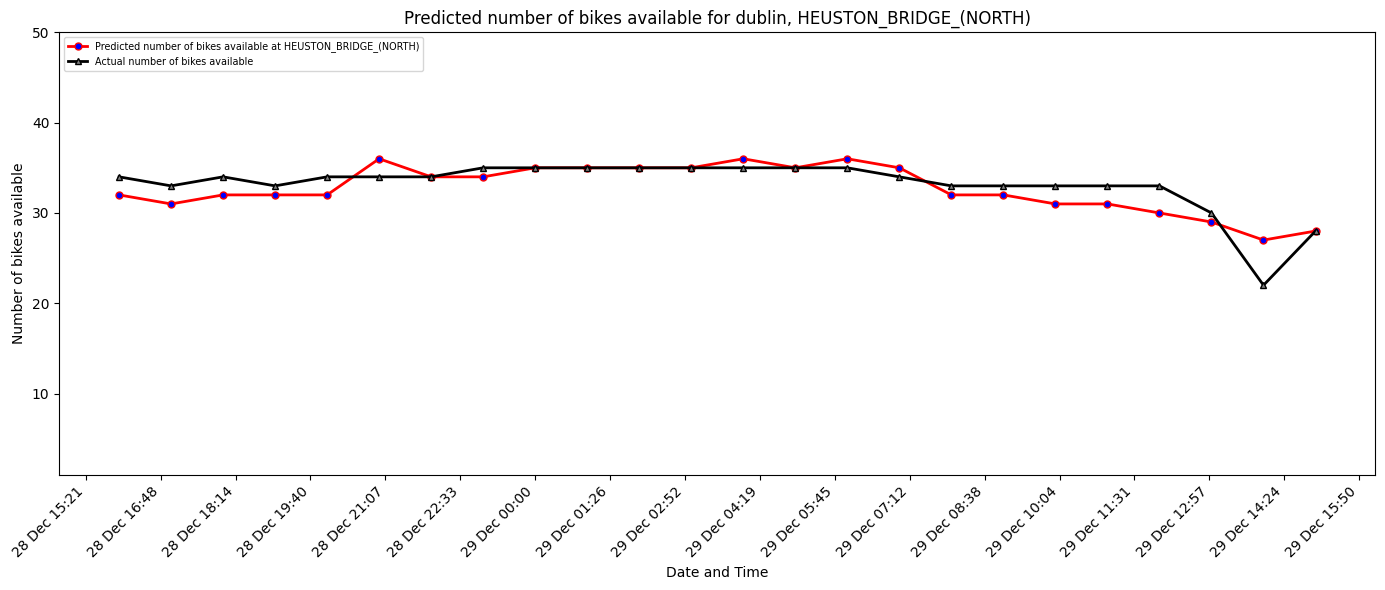

In [21]:
file_path = "docs/bike_availability_hindcast_1day.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, hindcast_df, file_path, hindcast=True)
plt.show()